In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import torch.nn.functional as F
from math import exp
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import math
import time
import torch.nn.utils as utils

In [2]:
#############Load data########################
xs = np.arange(-1, 1, 0.01)
func = torch.load('traindata_50000.pt')
func_t = torch.load('testdata_7000.pt')
##############2d#######################
#x1, x2 = np.linspace(-1, 1, 20), np.linspace(-1, 1, 20)
#xi, yi = np.meshgrid(x1, x2)
#func = torch.load('traindata_50000_2d.pt')
#func_t = torch.load('testdata_7000_2d.pt')

In [3]:
############parameters################################
# set random seed to 77
np.random.seed(77)
torch.manual_seed(77)

n=50000

epoch=100
batch=25
save_freq=10
    
step=20
future=0
hidden_size=64
learning_rate=1e-2
sigma=0.1

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array- value.data.numpy())).argmin()
    return idx

In [5]:
#input x and output y 
def query(action,func):
    y_out=[]
    x_out=[]
    for i in range(action.size(0)):
        idx=find_nearest(xs,action[i])
        y=func[i][idx]
        x_out.extend([xs[idx]])
        y_out.extend([y])
    x_out=np.array(x_out).reshape(action.size(0),1)
    x_out=torch.from_numpy(x_out[:])
    y_out=np.array(y_out).reshape(action.size(0),1)
    y_out=torch.from_numpy(y_out[:,:])
    input=torch.cat((x_out,y_out),1)
    return input,x_out,y_out

In [6]:
### 2 dimension ####input x and output y 
def query_2d(action,func):
    y_out=[]
    x1_out=[]
    x2_out=[]
    for i in range(action.size(0)):
        idx1=find_nearest(x1,action[i][0])
        idx2=find_nearest(x2,action[i][1])
        y=func[i][idx1][idx2]
        x1_out.extend([x1[idx1]])
        x2_out.extend([x2[idx2]])
        y_out.extend([y])
    x1_out=np.array(x1_out).reshape(func.size(0),1)
    x1_out=torch.from_numpy(x1_out[:]).double()
    x2_out=np.array(x2_out).reshape(func.size(0),1)
    x2_out=torch.from_numpy(x2_out[:]).double()
    y_out=np.array(y_out).reshape(func.size(0),1)
    y_out=torch.from_numpy(y_out[:,:]).double()
    action=torch.cat((x1_out,x2_out),1)
    input=torch.cat((x1_out,x2_out,y_out),1)
    return input,action,y_out

In [7]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(2,hidden_size) #1d:2 #2d:3
        self.linear1= nn.Linear(hidden_size,1)  #1d:1 #2d:2
        self.tanh=nn.Tanh()
        
    def forward(self,input,func,future=0):
        outputs = []
        log_probs = []
        rewards = []
        entropies = []
        actions = []
        
        h_t = torch.zeros(input.size(0), hidden_size, requires_grad=False, dtype=torch.double).cuda()
        c_t = torch.zeros(input.size(0), hidden_size, requires_grad=False, dtype=torch.double).cuda()

        outputs += [input]
        
        for i in range(step+future):
            h_t, c_t = self.lstm1(input, (h_t, c_t))
            h_t=h_t.detach()
            c_t=c_t.detach()
            mean=self.linear1(h_t)
            mean=self.tanh(mean)
            # output mean
            
            m = torch.distributions.normal.Normal(mean,sigma)
            action=m.sample()
            entropy=m.entropy()
            
            #next input
            input,action_new,reward=query(action.cpu(),func)
            log_prob=m.log_prob(action_new.cuda())
         
            input=input.cuda()
            outputs += [input]
            
            log_probs.append(log_prob)
            rewards.append(reward)
            entropies.append(entropy)
            actions.append(action_new)
               
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs,log_probs,rewards,entropies,actions      

In [8]:
# min value at every step
def min_loss(rewards):
        min_step=[]    
        min_step_each=[] 
        min=rewards[0].clone()
        for i in range(len(rewards)):
            for j in range(rewards[i].size(0)):
                if rewards[i][j]<min[j]:
                    min[j]=rewards[i][j]
            min_step.append(min.mean())
            min_step_each.append(min.clone())   
        return min_step,min_step_each

In [9]:
#LOSS OI
def OI_loss(rewards):
    _,min_step= min_loss(rewards)
    R = torch.zeros(1, 1).double()
    R=rewards[0]*-1 
    for i in range(len(rewards)-1):
        for j in range(rewards[i].size(0)):
            if rewards[i+1][j]-min_step[i][j]<0:
                R[j] += (rewards[i+1][j]-min_step[i][j])*-1
            else :
                R[j] += 0.0 
    return R

In [10]:
#Loss OI
def reinforce_OI(log_probs,rewards,entropies):
    loss = 0
    R=OI_loss(rewards)
    for i in reversed(range(len(rewards))):
        loss = loss - (log_probs[i]*(Variable(R-R.mean()).expand_as(log_probs[i])).cuda()).sum()- (0.0001*entropies[i]).sum()
    loss = loss / len(rewards[0])/ len(rewards)
    return loss

In [11]:
#Loss SUM
def reinforce_sum(log_probs,rewards,entropies):
    R = torch.zeros(1, 1).double()
    loss = 0
    for i in range(len(rewards)):
        R = 0.9*R+ rewards[i]*-1
    for i in reversed(range(len(rewards))):
        loss = loss - (log_probs[i]*(Variable(R-R.mean()).expand_as(log_probs[i])).cuda()).sum()- (0.0001*entropies[i]).sum()
    loss = loss / len(rewards) / len(rewards[0])
    return loss

In [12]:
#Loss MIN
def reinforce_min(log_probs,rewards,entropies):
    R = torch.zeros(1, 1).double()
    loss = 0
    min_step=min_loss(rewards)
    R=min_step[-1]*-1
    for i in reversed(range(len(rewards))):     
        loss = loss - (log_probs[i]*(Variable(R-R.mean()).expand_as(log_probs[i])).cuda()).sum()- (0.0001*entropies[i]).sum()
    loss = loss / len(rewards) / len(rewards[0])
    return loss

In [13]:
if __name__ == '__main__':

    func=np.array(func)
    func_t=np.array(func_t)
    func_test = torch.from_numpy(func_t[0:2000, :])
    #starting point
    x0=torch.tensor([0.0]*func_test.size(0))
    input_test,_,_=query(x0,func_test)
    #####2d#####
    #x0=torch.stack((x0,x0),dim=1)
    #input_test,_,_=query_2d(x0,func_test)
    input_test=input_test.cuda()
    
    training_loss=[]
    testing_loss=[]
    
    # build the model
    seq = Sequence().cuda()
    seq.double()
    
    #load model
    #seq.load_state_dict(torch.load('seq40_100.pkl'))
    
    # use ADAM as optimizer 
    optimizer = optim.Adam(seq.parameters(), lr=learning_rate)
    #scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,0.95, last_epoch=-1)
    t0 = time.time()
    

    #begin to train
    for i in range(epoch):
        print('EPOCH: ', i)
        
        for j in range(int(n/batch)):
            func_train = torch.from_numpy(func[batch*j:batch*(j+1), :])
            x0=torch.tensor([0.0]*func_train.size(0))
            input,_,_=query(x0,func_train)
            #####2d#####
            #x0=torch.stack((x0,x0),dim=1)
            #input,_,_=query_2d(x0,func_train)
            input=input.cuda()
        
            optimizer.zero_grad()
            out,log_probs,rewards,entropies,actions = seq(input,func_train)
            loss=reinforce_sum(log_probs,rewards,entropies)
            training_loss.append(loss)
            loss.backward()
            utils.clip_grad_norm_(seq.parameters(), 6)
            optimizer.step()
            
        with torch.no_grad():
            out_test,log_probs,test_rewards,entropies,test_actions = seq(input_test,func_test,future)
            min_step,_=min_loss(test_rewards)
            print('test loss:', min_step[-1].item())
            testing_loss.append(min_step[-1].item())
            y = out_test.cpu().detach().numpy()
            
        print('time : {:.02e} seconds'.format(time.time() - t0))
    
    ########save model#######################
        #if (i+1) % save_freq == 0: 
        #    torch.save(seq.state_dict(), 'seq40_%d.pkl'%(i+1)) 
            
            

EPOCH:  0
test loss: -0.5889265805622378
time : 8.37e+01 seconds
EPOCH:  1
test loss: -0.6873107239770003
time : 1.47e+02 seconds
EPOCH:  2
test loss: -0.766587840728818
time : 2.36e+02 seconds
EPOCH:  3
test loss: -0.8899706039013341
time : 3.11e+02 seconds
EPOCH:  4
test loss: -0.9390088061814256
time : 3.87e+02 seconds
EPOCH:  5
test loss: -0.9193508955039411
time : 4.62e+02 seconds
EPOCH:  6
test loss: -0.9412989673882002
time : 5.38e+02 seconds
EPOCH:  7
test loss: -0.9369850345604274
time : 6.14e+02 seconds
EPOCH:  8
test loss: -0.9397052606526886
time : 7.02e+02 seconds
EPOCH:  9
test loss: -0.9467946172009698
time : 7.84e+02 seconds
EPOCH:  10
test loss: -0.9420195539892846
time : 8.59e+02 seconds
EPOCH:  11
test loss: -0.9438899069008064
time : 9.34e+02 seconds
EPOCH:  12
test loss: -0.9451292513985927
time : 1.02e+03 seconds
EPOCH:  13
test loss: -0.9183471466589056
time : 1.10e+03 seconds
EPOCH:  14
test loss: -0.9620576504406841
time : 1.17e+03 seconds
EPOCH:  15
test loss:

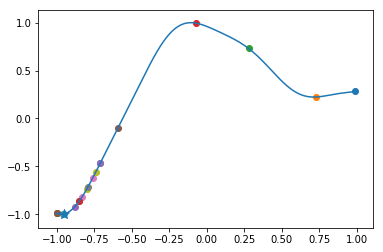

In [14]:
#training plot
y = out.cpu().detach().numpy()
k=0
plt.plot(xs,func[n-batch+k])
for i in range(20):
    plt.scatter(y[k][i+1][0],y[k][i+1][1])
plt.scatter(y[k][20][0],y[k][20][1],marker='*',s=100)
plt.show()
plt.close()

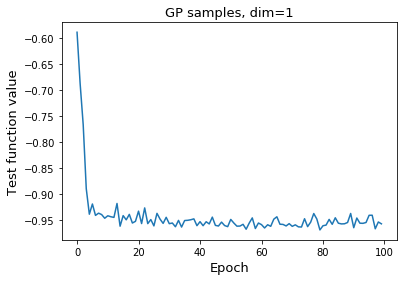

-0.9575208987423716


In [15]:
plt.plot(testing_loss)

plt.xlabel('Epoch',size=13)
plt.ylabel('Test function value',size=13)
plt.title('GP samples, dim=1',size=13)
plt.show()
print(testing_loss[-1])

In [16]:
#np.save('test_50000_100.npy',testing_loss)

In [17]:
#testing 
f=44
func_t=np.array(func_t)
func_test = torch.from_numpy(func_t[f:f+1, :])
x0=torch.tensor([0.0]*func_test.size(0))
input_test,_,_=query(x0,func_test)
input_test=input_test.cuda()
with torch.no_grad():
            out_test,log_probs,test_rewards,entropies,test_actions = seq(input_test,func_test,future)
            min_step,_=min_loss(test_rewards)
            print('test loss:', min_step[-1].item())
            y = out_test.cpu().detach().numpy()

test loss: -0.9968363767745191


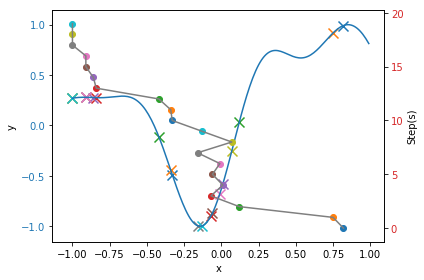

In [18]:
##### 1d  search trajectory######

k = 0
x = torch.linspace(0, 1)

color = 'tab:blue'
fig,ax1= plt.subplots()
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax1.plot(xs,func_t[f])


ax1.tick_params(axis='y', labelcolor=color)
for i in range(step+future):
    ax1.scatter(y[k][i+1][0],y[k][i+1][1],marker='x',s=100)
    
ax2 = ax1.twinx()
steps = np.arange(0, step+future, 1)
color = 'tab:red'
ax2.set_ylabel('Step(s)')  

ax2.plot(test_actions,steps, color='tab:grey')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(np.arange(0, step+future+1, 5))
for i in range(step+future):
    ax2.scatter(test_actions[i],i)

fig.tight_layout() 

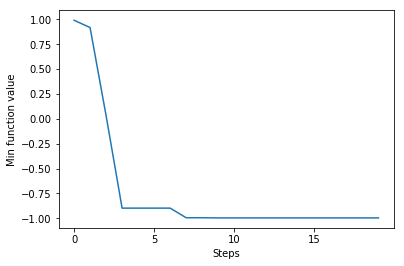

In [19]:
####min function value
plt.plot(min_step)
plt.xticks(np.arange(0, step+future, 5))
plt.ylabel('Min function value') 
plt.xlabel('Steps')
plt.show()

In [20]:
##### 2d  search trajectory######

#zi=func_t[f]

#im=plt.imshow(zi, vmin=zi.min(), vmax=zi.max(),origin='lower',extent=[-1,1,-1,1])#, cmap=plt.cm.hot)

#idx_z=np.where(zi==zi.min())
#for i in range(len(idx_z[0])):
#    plt.scatter(x1[idx_z[1][i]],x2[idx_z[0][i]], c='red')

#for i in range(len(test_actions)):
#    plt.scatter(test_actions[i][0][1],test_actions[i][0][0], c='yellow')
    
#plt.colorbar(im)
#plt.contourf(x1, x2,zi, 8, alpha=0.05)#, cmap=plt.cm.hot) 
#C = plt.contour(x1, x2,zi, 8, colors='black')
#plt.clabel(C, inline=True, fontsize=10)
#plt.show()